This notebook is divided into the following sections.

## 0. Import Libraries
<div id="0">
</div>

In [75]:
# Load Data
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt

# Model Training
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2, l1_l2

A a GPU would speed up the training process 


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU")
    except RuntimeError as e:
        print(e)
else:
    print("Pas de GPU trouvé")

1 Physical GPUs, 1 Logical GPU


## 1. Load Data
<div id="1">
</div>

Define the data directories now.

In [5]:
train_dir = 'data/processed/train'
test_dir =  'data/processed/test'

In [6]:
import random

def get_data(data_dir):
    images = []
    labels = []
    
    dir_list = os.listdir(data_dir)
    for i in range(len(dir_list)):
        print("Obtaining images of", dir_list[i], "...")
        for image in os.listdir(data_dir + "/" + dir_list[i]):
            img = np.load(data_dir + '/' + dir_list[i] + '/' + image)
            images.append(img)
            labels.append(i)

    return images, labels
        
X_train, y_train = get_data(train_dir)
X_test, y_test = get_data(test_dir)

print("==== Fini ! ====")

Obtaining images of bird ...
Obtaining images of boar ...
Obtaining images of dog ...
Obtaining images of dragon ...
Obtaining images of hare ...
Obtaining images of horse ...
Obtaining images of monkey ...
Obtaining images of ox ...
Obtaining images of ram ...
Obtaining images of rat ...
Obtaining images of snake ...
Obtaining images of tiger ...
Obtaining images of zero ...
Obtaining images of bird ...
Obtaining images of boar ...
Obtaining images of dog ...
Obtaining images of dragon ...
Obtaining images of hare ...
Obtaining images of horse ...
Obtaining images of monkey ...
Obtaining images of ox ...
Obtaining images of ram ...
Obtaining images of rat ...
Obtaining images of snake ...
Obtaining images of tiger ...
Obtaining images of zero ...
==== Fini ! ====


verify the size of both X and y, to ensure all the data is read.

In [7]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

1813 1813
63 63


## 2. Data Visualisation
<div id="2">
</div>

Before preprocessing our data,  explore and gain insight into the images we are dealing with. For simplicity, load one sample image from each class.

In [8]:
classes = ['bird', 'boar', 'dog', 'dragon', 'hare', 'horse', 'monkey', 'ox', 'ram', 'rat', 'snake', 
           'tiger', 'zero']

## 3. Data Preprocessing
<div id="3">
</div>

Before feeding the data to our model, we convert into numpy arrays and normalise the values by dividing the image pixel values by 255. 
Then, we divide our training data into training and testing sets to be used by the model.

In [1]:
def preprocess_data(X, y):
    np_X = np.array(X)
    normalised_X = np_X.astype('float32')/255.0
    
    label_encoded_y = utils.to_categorical(y)
    return normalised_X, label_encoded_y

x_train, y_train = preprocess_data(X_train, y_train)
x_test, y_test = preprocess_data(X_test, y_test)


NameError: name 'X_train' is not defined

confirm the size of training and testing data.

In [11]:
print("Training data x:", x_train.shape)
print("Training data y:", y_train.shape)
print("Test data x:", x_test.shape)
print("Test data y:", y_test.shape)

Training data x: (1813, 224, 224, 3)
Training data y: (1813, 13)
Test data x: (63, 224, 224, 3)
Test data y: (63, 13)


## 4. Define CNN Model
<div id="4">
</div>

Next, we define the architecture of our custom CNN Model. 

In [12]:
classes = 13
batch = 32
learning_rate = 0.001

For our model, initialize a Keras Sequential model. 

The defined model is a 4 layer deep CNN model. Batch normalisation and dropout layers have been added to avoid overfitting on the training set and perform regularization.
The three CNN layers have been flattened out and connected to a dense layer before performing classification using the softmax activation function.

Try to maximum validation accuracy.

In [76]:
# pretrained model
# base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Freeze the convolutional layers
# for layer in base_model.layers:
#     layer.trainable = False

# Freeze the convolutional layers but not all
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True




# Create a custom model
model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())

model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))

model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(classes, activation='softmax'))

In [56]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 spatial_dropout2d_1 (Spatia  (None, 7, 7, 2048)       0         
 lDropout2D)                                                     
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_29 (Bat  (None, 100352)           401408    
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 100352)            0         
                                                                 
 dense_10 (Dense)            (None, 128)              

Adam is used as the optimizer
Since this is a multiclass classification, categorical crossentropy is chosen as the loss function. The model is trained on the metric of accuracy.

In [57]:
adam = Adam(learning_rate)
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

The summary of our CNN architecture can be seen below. 


In [69]:
# Paramètres de data augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    # brightness_range=[0]
)
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch
)

validation_generator = validation_datagen.flow(
    x_test,
    y_test,
    batch_size=batch
)

## 5. Train Model
<div id="5">
</div>

In [70]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,  # Nombre d'époques sans amélioration après lequel l'entraînement sera arrêté
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Facteur de réduction du taux d'apprentissage
    patience=3,  # Nombre d'époques avec aucune amélioration après lequel le taux d'apprentissage sera réduit
    min_lr=0.00001  # Taux d'apprentissage minimal
)

In [71]:
# history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, shuffle = True, verbose=1)

# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, shuffle = True, verbose=1)

history = model2.fit(train_generator, validation_data=validation_generator, epochs=25, shuffle = True, verbose=1,callbacks=[early_stopping, reduce_lr]) #Compilation avec un taux d'apprentissage adaptatif

# history = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, shuffle = True, verbose=1)

Epoch 1/25
57/57 [==============================] - 15s 262ms/step - loss: 0.3407 - accuracy: 0.9972 - val_loss: 1.2482 - val_accuracy: 0.6984 - lr: 1.0000e-05
Epoch 2/25
57/57 [==============================] - 15s 265ms/step - loss: 0.3175 - accuracy: 0.9978 - val_loss: 1.2345 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 3/25
57/57 [==============================] - 15s 261ms/step - loss: 0.2989 - accuracy: 0.9983 - val_loss: 1.2176 - val_accuracy: 0.6825 - lr: 1.0000e-05
Epoch 4/25
57/57 [==============================] - 15s 260ms/step - loss: 0.2831 - accuracy: 0.9972 - val_loss: 1.1971 - val_accuracy: 0.7302 - lr: 1.0000e-05
Epoch 5/25
57/57 [==============================] - 15s 260ms/step - loss: 0.2722 - accuracy: 0.9967 - val_loss: 1.2261 - val_accuracy: 0.7619 - lr: 1.0000e-05
Epoch 6/25
57/57 [==============================] - 15s 258ms/step - loss: 0.2614 - accuracy: 0.9978 - val_loss: 1.2233 - val_accuracy: 0.7302 - lr: 1.0000e-05
Epoch 7/25
57/57 [======================

## 6. Evaluate Model
<div id="6">
</div>

evaluate on the test data.

In [72]:
test_loss, test_acc = model2.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

2/2 [==============================] - 0s 110ms/step - loss: 1.1971 - accuracy: 0.7302
Test accuracy: 0.7301587462425232
Test loss: 1.1971435546875


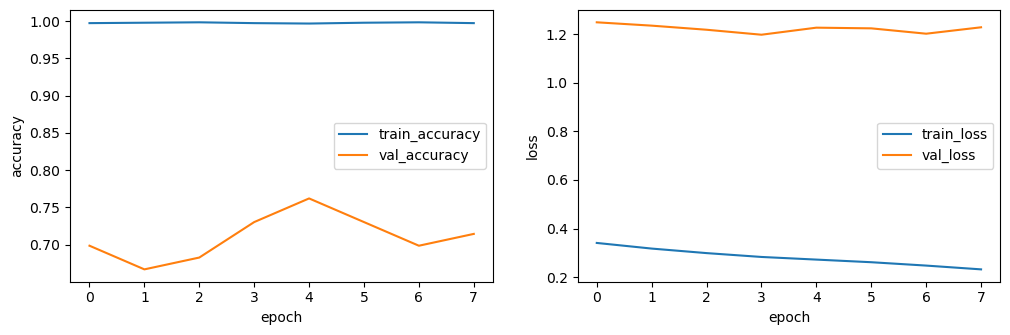

In [73]:
def plot_results(model):

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(history.history['accuracy'], label = 'train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


    
plot_results(model2)

In [74]:
import os

model_dir = "model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
model2.save("model/xception.keras")